<a href="https://colab.research.google.com/github/BugraKaytanli/Prediction-of-Finger-Flexion-from-ECoG/blob/main/ECoG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pandas as pd


In [6]:
# Read the measurement data

# From electrode array
trs = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ECoG_dataset/trs.csv', header=None, delimiter=",")
trs = trs.to_numpy()
# From glove
tgs = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ECoG_dataset/tgs.csv', header=None, delimiter=",")
tgs = tgs.to_numpy()

# Print data shapes to confirm all data is imported.
print(trs.shape)
print(tgs.shape)


(400000, 64)
(400000, 5)


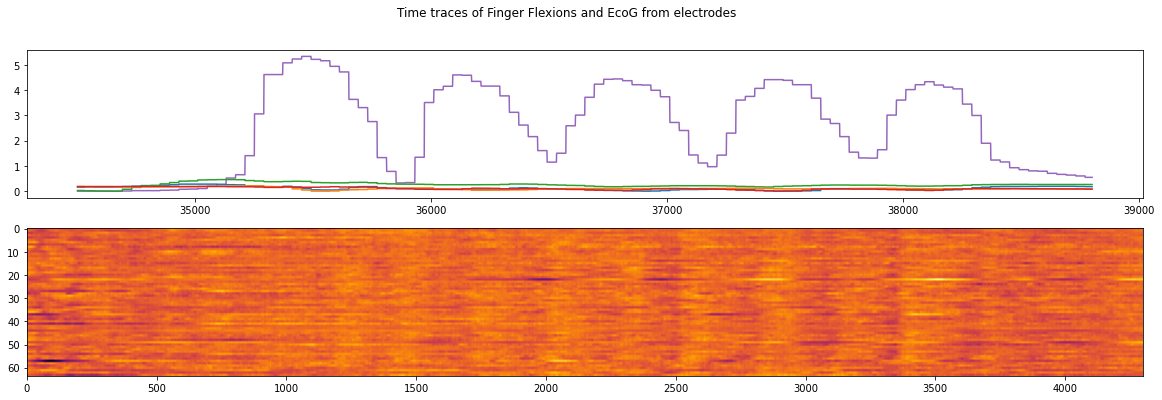

In [8]:
#plt.plot(tgs[0:12000,0])

fig, axs = plt.subplots(2)
fig.suptitle('Time traces of Finger Flexions and EcoG from electrodes')

t_end=tgs.shape
t= range(1,t_end[0])

startplot=34500; endplot=38800; incrementplot=1;

# Assume delay between ECoG and Flexion data is 50ms=37ms(measurement)+13ms(phsysiological cortico-muscular delay)
tg=tgs[startplot-50:endplot-50:incrementplot,:]
tgm=tg-np.amin(tg,axis=0)

tr=trs[startplot:endplot:incrementplot,:]
tt=t[startplot:endplot:incrementplot]

axs[0].plot(tt,tgm[:,0],'tab:purple')
axs[0].plot(tt,tgm[:,1],'tab:blue')
axs[0].plot(tt,tgm[:,2],'tab:green')
axs[0].plot(tt,tgm[:,3],'tab:orange')
axs[0].plot(tt,tgm[:,4],'tab:red')

axs[1].imshow(tr.transpose(),cmap="inferno",aspect='auto',interpolation=None)
axs[0].set_xlabel='time(ms)'
plt.rcParams["figure.figsize"] = (20,6)
plt.colorbar
plt.show()
plt.rcParams["figure.figsize"] = (20,6)

(4300,)


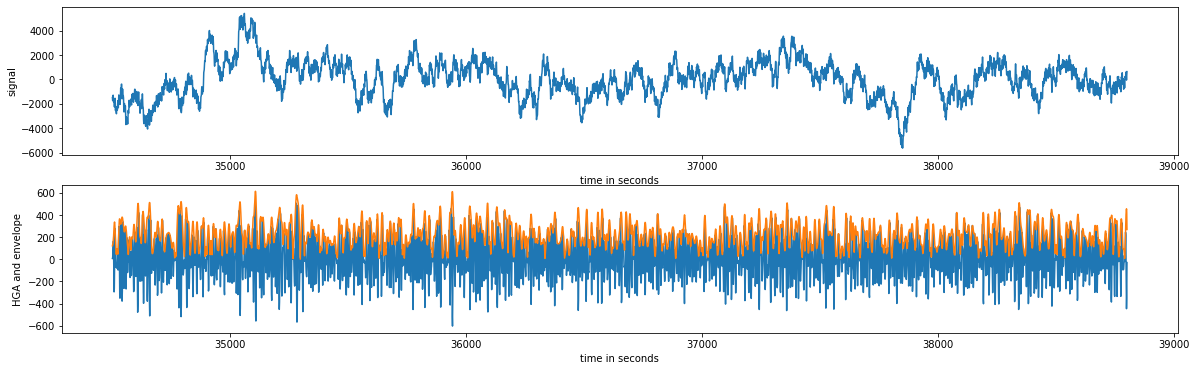

In [9]:
from scipy.signal import hilbert, butter, filtfilt

sampling_rate = 1000.0
nyq=sampling_rate*0.5

b, a = scipy.signal.iirnotch(60, 10, sampling_rate)
y = filtfilt(b, a, tr[:,0])

passband = [70/nyq, 190/nyq]
b, a = butter(5, passband, 'bandpass')
y = filtfilt(b, a, y)
analytic_signal = hilbert(y)
amplitude_envelope = np.abs(analytic_signal)

fig, (ax0, ax1) = plt.subplots(nrows=2)
ax0.plot(tt, tr[:,0], label='signal')
ax0.set_xlabel("time in seconds")
ax0.set_ylabel("signal")

# ax1.plot(tt, tr[:,0], label='signal')
ax1.plot(tt, y, label='hilbert')
ax1.plot(tt, amplitude_envelope, label='envelope')
ax1.set_xlabel("time in seconds")
ax1.set_ylabel("HGA and envelope")

print(analytic_signal.shape)

In [10]:
y=tr
for i in [1,2,3,4]:
  b, a = scipy.signal.iirnotch(60*i, 30, sampling_rate)
  y = filtfilt(b, a, y, axis=0)

passband = [70/nyq, 190/nyq]
b, a = butter(5, passband, 'bandpass')
y = filtfilt(b, a, y)
analytic_signal = hilbert(y)
amplitude_envelope = np.abs(analytic_signal)

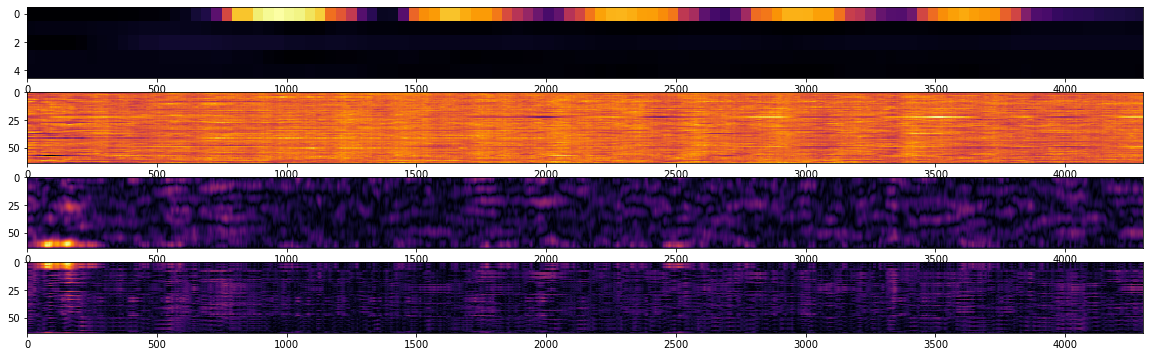

In [12]:
plt.subplot(411)
plt.rcParams["figure.figsize"] = (20,6)
plt.rcParams["image.interpolation"] = None
plt.imshow(tgm.transpose(),cmap="inferno",aspect='auto',interpolation=None)
plt.subplot(412)
plt.imshow(tr.transpose(),cmap="inferno",aspect='auto',interpolation=None)
plt.rcParams["figure.figsize"] = (20,6)
plt.rcParams["image.interpolation"] = None
plt.subplot(413)
plt.imshow(amplitude_envelope.transpose(),cmap="inferno",aspect='auto',interpolation=None)
plt.rcParams["figure.figsize"] = (20,6)
plt.rcParams["image.interpolation"] = None
plt.subplot(414)
plt.imshow(amplitude_envelope_sorted[:,::].transpose(),cmap="inferno",aspect='auto',interpolation=None)
plt.rcParams["figure.figsize"] = (20,6)
plt.rcParams["image.interpolation"] = None


# plt.show()
# plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
# cax = plt.axes([0.85, 0.1, 0.075, 0.8])
# plt.colorbar(cax=cax)

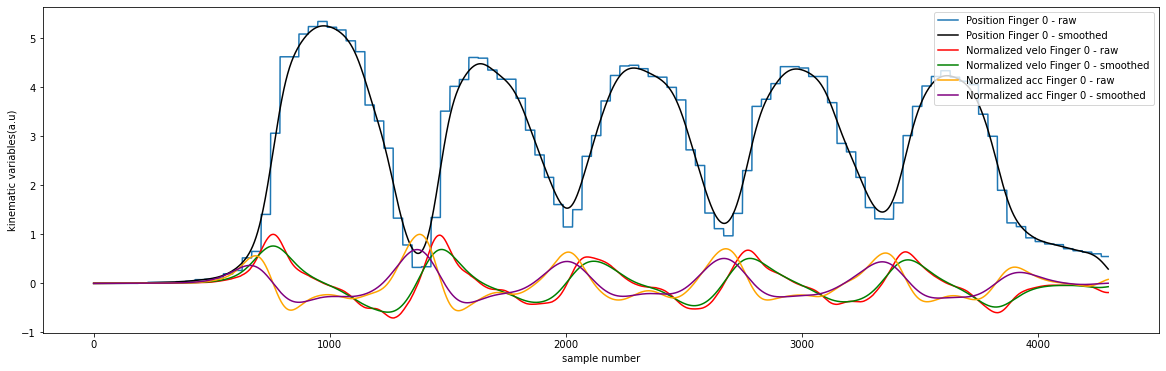

4300 4300 4300


In [115]:
# Generate position/velocity/acceleration trajectories of the fingers

import cv2
filter_size_pts=251
y=tgm[:,0]
def smooth(y, box_pts,filter_type):
    box = np.ones(box_pts)/box_pts
    gauss = cv2.getGaussianKernel(box_pts, box_pts/6)
    gauss=gauss.squeeze() # this is to go from xby1 array to xby0 array to make convolutional filtering work.
    y_smooth = np.convolve(y, eval(filter_type), mode='same')
    return y_smooth

fig = plt.figure
plt.rcParams["figure.figsize"] = (20,6)
plt.plot(y)
tgm_sm=smooth(y,filter_size_pts,'gauss')
plt.plot(tgm_sm,color='black')

dydx = np.gradient(tgm_sm)
v_tgm_sm=smooth(dydx,filter_size_pts+50,'gauss')

ddyddx = np.gradient(v_tgm_sm)
a_tgm_sm=smooth(ddyddx,filter_size_pts+100,'gauss')


plt.plot(dydx/max(dydx),color='red')
plt.plot(v_tgm_sm/max(dydx),color='green')
plt.plot(ddyddx/max(ddyddx),color='orange')
plt.plot(a_tgm_sm/max(ddyddx),color='purple')

plt.xlabel("sample number")
plt.ylabel("kinematic variables(a.u)")
plt.legend(['Position Finger 0 - raw', 'Position Finger 0 - smoothed','Normalized velo Finger 0 - raw', 'Normalized velo Finger 0 - smoothed','Normalized acc Finger 0 - raw', 'Normalized acc Finger 0 - smoothed'],loc='upper right')
plt.show()
print(y.size, tgm_sm.size, v_tgm_sm.size)

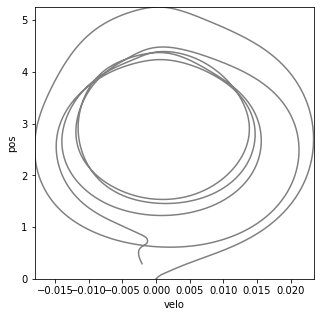

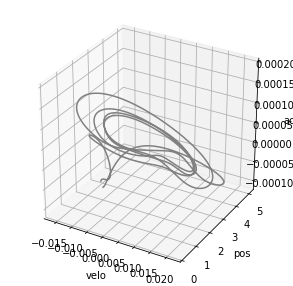

In [118]:
# Generate the position/velocity/acceleration
fig = plt.figure
plt.rcParams["figure.figsize"] = (5,5)
plt.plot(v_tgm_sm,tgm_sm,'gray')
plt.xlim(min(v_tgm_sm), max(v_tgm_sm))
plt.ylim(min(tgm_sm), max(tgm_sm))
plt.xlabel('velo')
plt.ylabel('pos')
plt.gca().set_adjustable('box')
plt.draw()

from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(v_tgm_sm, tgm_sm, a_tgm_sm, 'gray')
ax.set_xlim(min(v_tgm_sm), max(v_tgm_sm))
ax.set_ylim(min(tgm_sm), max(tgm_sm))
ax.set_zlim(min(a_tgm_sm), max(a_tgm_sm))
plt.axis([min(v_tgm_sm), max(v_tgm_sm), min(tgm_sm), max(tgm_sm)])
ax.set_xlabel('velo')
ax.set_ylabel('pos')
ax.set_zlabel('acc')
plt.gca().set_adjustable('box')
plt.draw()


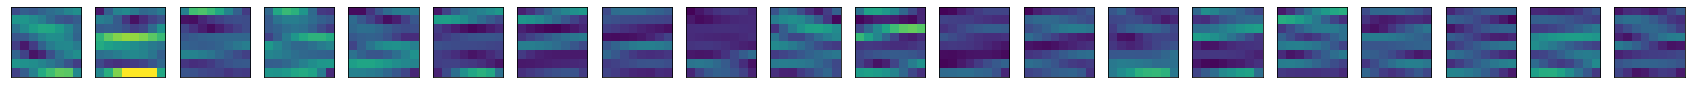

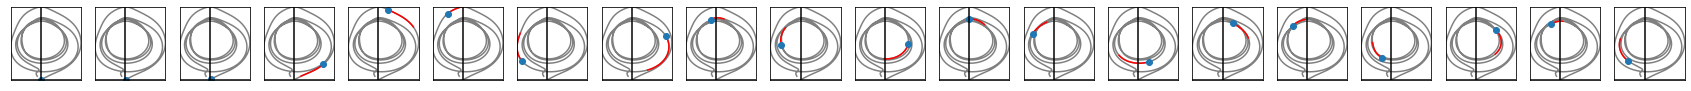

In [104]:
amplitude_envelope_reshaped=amplitude_envelope.reshape(-1,8,8)
# print(amplitude_envelope.shape)
fig, axes = plt.subplots(1,20,figsize=(30,30) )
vmini=np.min(amplitude_envelope_reshaped)
vmaxi=np.max(amplitude_envelope_reshaped)
# print([vmini, vmaxi])
for i,ax in enumerate(axes.flat):
  arr=amplitude_envelope_reshaped[i*200,:,:]
  for j in np.arange(1,9,9):
    arr=arr+ amplitude_envelope_reshaped[i*200+j,:,:]
  # arr /=10
  ax.imshow(arr,vmin=vmini,vmax=vmaxi)
  ax.set_xticks([])
  ax.set_yticks([])


fig, axes = plt.subplots(1,20, figsize=(30,1.35))
for i,ax in enumerate(axes.flat):
  # arr=amplitude_envelope_reshaped[i*200,:,:]
  # for j in [1,2,3,4,5,6,7,8,9]:
  # #   arr=arr+ amplitude_envelope_reshaped[i*200+j,:,:]
  # # arr /=10
  ax.plot(v_tgm_sm,tgm_sm,color='gray')
  ax.plot(v_tgm_sm[i*200:i*200+100],tgm_sm[i*200:i*200+100],color='red')
  ax.plot(v_tgm_sm[i*200+100],tgm_sm[i*200+100],'o')
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_xlim(min(v_tgm_sm), max(v_tgm_sm))
  ax.set_ylim(min(tgm_sm), max(tgm_sm))
  ax.axhline(y=0, color='k')
  ax.axvline(x=0, color='k')




# for i,ax in enumerate(axes.flat):
#     ax.imshow(amplitude_envelope_reshaped[i*200,:,:])


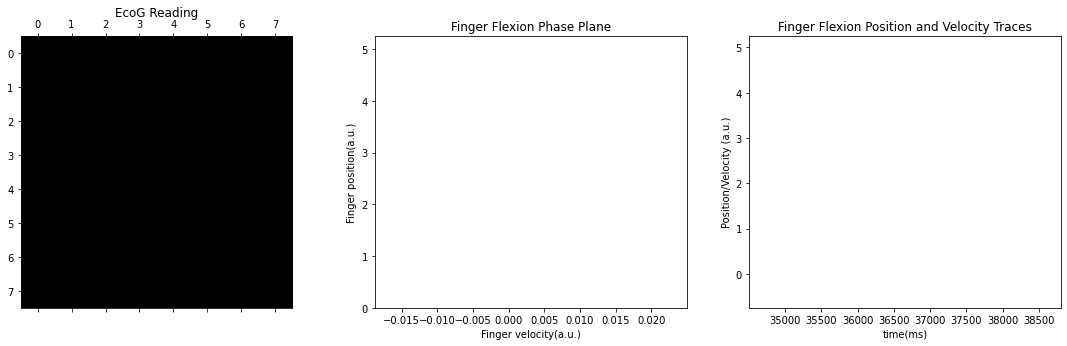

In [112]:
# Initialize axes settings for animation plotting

# create a figure and axes
fig = plt.figure(figsize=(19,5))
ax1 = plt.subplot(1,3,1)   
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(1,3,3)   


# set up the subplots as needed
ax1.set_title('EcoG reading')


ax2.set_xlim(min(v_tgm_sm), max(v_tgm_sm))
ax2.set_ylim(min(tgm_sm), max(tgm_sm))
ax2.set_xlabel('Finger velocity(a.u.)')
ax2.set_ylabel('Finger position(a.u.)')
ax2.set_title('Finger Flexion Phase Plane')
ax2.set_adjustable('box')

ax3.set_title('Finger Flexion Position and Velocity Traces')
ax3.set_xlabel('time(ms)')
ax3.set_ylabel('Position/Velocity (a.u.)')
ax3.set_xlim(min(tt), max(tt))
ax3.set_ylim(min(v_tgm_sm/max(np.abs(v_tgm_sm))), max(tgm_sm))
# ax3.set_legend(['Position Finger 0 - raw', 'Position Finger 0 - smoothed','Normalized velo Finger 0 - raw', 'Normalized velo Finger 0 - smoothed','Normalized acc Finger 0 - raw', 'Normalized acc Finger 0 - smoothed'],loc='upper right')


# create objects that will change in the animation. These are
# initially empty, and will be given new values for each frame
# in the animation.
txt_title = ax1.set_title('EcoG Reading')
# ecog_image_display = ax1.matshow(np.zeros([8, 8]),cmap='gray',vmin=vmini.astype('uint8'),vmax=vmaxi.astype('uint8'))
ecog_image_display = ax1.matshow(np.zeros([8, 8]),cmap='gray',vmin=0,vmax=255)
# ecog_image_display = ax1.matshow([[]],vmin=vmini,vmax=vmaxi)
pt1, = ax2.plot([], [], 'r.', ms=20)
line1, = ax2.plot([], [], 'r', lw=4)
line2, = ax2.plot([], [], 'gray', lw=2)

pt3, = ax3.plot([], [], 'r.', ms=20)
line3, = ax3.plot([], [], 'r', lw=4)
line4, = ax3.plot([], [], 'blue', lw=2)

pt5, = ax3.plot([], [], 'r.', ms=20)
line5, = ax3.plot([], [], 'r', lw=4)
line6, = ax3.plot([], [], 'pink', lw=2)


In [113]:
# animation function. This is called sequentially
def drawframe(n):
    img = Image.fromarray(amplitude_envelope_reshaped[n*20,:,:].astype('uint8'),'L')
    img= img.resize([160,160])
    ecog_image_display.set_data(img)
    line2.set_data(v_tgm_sm,tgm_sm)
    line1.set_data(v_tgm_sm[n*20-40:n*20],tgm_sm[n*20-40:n*20])
    pt1.set_data(v_tgm_sm[n*20],tgm_sm[n*20])

    line4.set_data(tt,tgm_sm)
    line3.set_data(tt[n*20-40:n*20],tgm_sm[n*20-40:n*20])
    pt3.set_data(tt[n*20],tgm_sm[n*20])
    line6.set_data(tt,v_tgm_sm/max(np.abs(v_tgm_sm)))
    line5.set_data(tt[n*20-40:n*20],v_tgm_sm[n*20-40:n*20]/max(np.abs(v_tgm_sm)))
    pt5.set_data(tt[n*20],v_tgm_sm[n*20]/max(np.abs(v_tgm_sm)))

    txt_title.set_text('EcoG Reading Frame = {0:4d}'.format(n))
    return (ecog_image_display,line1,line2,pt1,line4,line3,pt3,line6,line5,pt5)

from matplotlib import animation

# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=210, interval=100, blit=True)


In [108]:
from matplotlib import rc

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

In [114]:
anim

In [ ]:
# # Alternate (slower) visualization option

# from IPython.display import HTML
# HTML(anim.to_html5_video())